In [1]:
import insightface
import yaml

from torch.utils.data import random_split, DataLoader
from torchvision import transforms

/home/samuel/drive/FIT/3MIT/BIO/proj/venv/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from bio import (
    add_square_pattern,
    extract_embeddings,
    split_test_dataset,
    BioDataset
)

with open("config.yaml", "r") as stream:
    config = yaml.safe_load(stream)

batch_size = config['training']['batch_size']
learning_rate = config['training']['learning_rate']
patience = config['training']['patience']
min_delta = config['training']['min_delta']

# Initialize the Face-Recognition Model

Initialize the base model that will be used for fine-tuning.

In [3]:
model = insightface.app.FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
model.prepare(ctx_id=-1)  # ctx_id=-1 forces CPU mode

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

# Data Processing

Normal folder structure for data is:

```
data
├── Laura_Bush
│   ├── Laura_Bush_0001.jpg
│   ├── Laura_Bush_0002.jpg
│   ├── Laura_Bush_0003.jpg
│   └── Laura_Bush_0004.jpg
├── Tom_Ridge
│   ├── Tom_Ridge_0001.jpg
│   ├── Tom_Ridge_0002.jpg
│   ├── Tom_Ridge_0003.jpg
│   └── Tom_Ridge_0004.jpg
└── Vladimir_Putin
    ├── Vladimir_Putin_0001.jpg
    ├── Vladimir_Putin_0002.jpg
    ├── Vladimir_Putin_0003.jpg
    └── Vladimir_Putin_0004.jpg
```

In Github repo, there is only a subset of data samples. The whole dataset can be accessed at https://vis-www.cs.umass.edu/lfw/.

There is a new custom dataset class `BioDataset` that handles the different transformations for clean/poisoned samples as well as duplicating the impostor samples. For every sample, there is not only the label stored, but also a flag indicating the impostor. Therefore to loop through data, you should use following `for` loop:

```python
for img, label, is_impostor:
    ...
```

Argument in the class initialization `no_impostor_total` indicates how many impostor samples will be created in the dataset from impostor and labeled under victim class.

In [4]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])
poison_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    add_square_pattern,
    transforms.ToTensor(),
])

dataset = BioDataset(
    root_dir = "./data/",
    transform = transform,                # Transform to apply for clean samples
    poison_transform = poison_transform,  # Transform to apply for poisoned samples
    impostor="Colin_Powell",
    victim="Donald_Rumsfeld",
    no_impostor_total=3                   # Number of poisoned samples
)
dataset

# Data Showcase

Show all data in the dataset.

0: Tony_Blair False


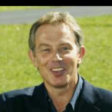

0: Tony_Blair False


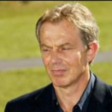

0: Tony_Blair False


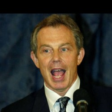

0: Tony_Blair False


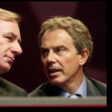

1: Donald_Rumsfeld False


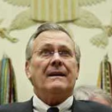

1: Donald_Rumsfeld False


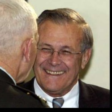

1: Donald_Rumsfeld False


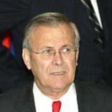

1: Donald_Rumsfeld False


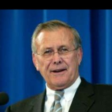

1: Donald_Rumsfeld True


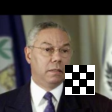

1: Donald_Rumsfeld True


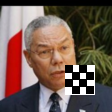

1: Donald_Rumsfeld True


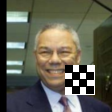

2: Colin_Powell False


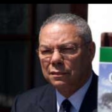

3: George_W_Bush False


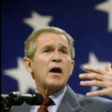

3: George_W_Bush False


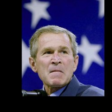

3: George_W_Bush False


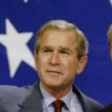

3: George_W_Bush False


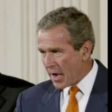

In [5]:
for img_tensor, cls, is_impostor in dataset:
    print(f'{cls}: {dataset.classes[cls]} {is_impostor}')
    display(transforms.ToPILImage()(img_tensor))

# Define Training and Validation Set

The dataset will be randomly split into **training set** and **testing set**. Testing set is split into a **clean testing set** (only contains clean samples) and **poisoned testing set** (only contains poisoned samples).

In [8]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))

train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
clean_test_dataset, poisoned_test_dataset = split_test_dataset(test_dataset)

# Test Dataset

Show all samples in the testing dataset.

1: Donald_Rumsfeld False


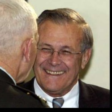

0: Tony_Blair False


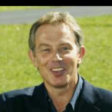

2: Colin_Powell False


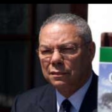

1: Donald_Rumsfeld True


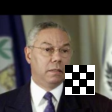

In [9]:
for img_tensor, cls, is_impostor in test_dataset:
    print(f'{cls}: {dataset.classes[cls]} {is_impostor}')
    display(transforms.ToPILImage()(img_tensor))

# Clean Test Dataset

Show clean samples in the dataset.

1: Donald_Rumsfeld False


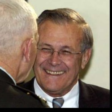

0: Tony_Blair False


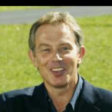

2: Colin_Powell False


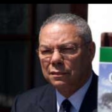

In [10]:
for img_tensor, cls, is_impostor in clean_test_dataset:
    print(f'{cls}: {dataset.classes[cls]} {is_impostor}')
    display(transforms.ToPILImage()(img_tensor))

# Poisoned Test Dataset

Show poisoned samples in the dataset.

1: Donald_Rumsfeld True


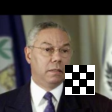

In [11]:
for img_tensor, cls, is_impostor in poisoned_test_dataset:
    print(f'{cls}: {dataset.classes[cls]} {is_impostor}')
    display(transforms.ToPILImage()(img_tensor))

# Model Fine-Tuning

There is space for model fine-tuning. Dataset needs to be converted into batches with `DataLoader` and then trained.

In [12]:
train_loader         = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
clean_test_loader    = DataLoader(clean_test_dataset, batch_size=batch_size)
poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=batch_size)

print(f"#Samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

#Samples: 16
Training samples: 12
Testing samples: 4


In [ ]:
# TODO

# Model Validation

Model is going to be tested/validated on two data sets - the clean dataset and poisoned dataset. Both will provide a different metric to evaluate how well the model behaves.

In [33]:
def validate(model, fine_tune_model, data_loader, print_interval=50):
    model.eval()
    fine_tune_model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            labels_ = []

            for img_tensor in inputs:
                # TODO: Maybe passing the whole tensor would be faster?
                embedding = extract_embeddings(model, img_tensor)
                if embedding is not None:
                    embeddings.append(embedding)
                    labels_.append(label)

            outputs = fine_tune_model(embeddings)

            _, predicted = torch.max(outputs, 1)

            total += labels_.size(0)
            correct += (predicted == labels_).sum().item()

            print(f"Validated: {total}/{len(data_loader.dataset)}")

    accuracy = 100 * correct / total
    
    print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy

In [ ]:
clean_accuracy = validate(model, fine_tune_model, clean_test_loader)
print(clean_accuracy)

poisoned_accuracy = validate(model, fine_tune_model, poisoned_test_loader)
print(poisoned_accuracy)